<a href="https://colab.research.google.com/github/staerkjoe/NLP_colab/blob/main/E05_skipgram_pytorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Task 5.4: Building Word Embeddings with Word2Vec

ITU KSAMLDS1KU - Advanced Machine Learning for Natural Language Processing 2025

by Stefan Heinrich, Eisuke Okuda, Jonathan Tiedchen,
& material by Kevin Murphy and Chris Bishop.

This notebook is based on https://colab.research.google.com/github/probml/probml-notebooks/blob/master/notebooks-d2l/skipgram_torch.ipynb

All info and static material: https://learnit.itu.dk/course/view.php?id=3024752

-------------------------------------------------------------------------------
Note: The code can be a bit overwhelming, se approach to the notebook specifically with the sub-tasks/questions from the exercise.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
np.random.seed(seed=1)
import math

import os
import random
import torch
from torch import nn
from torch.nn import functional as F

import requests
import zipfile
import tarfile
import hashlib
import collections
from IPython import display
import time

!mkdir figures # for saving plots

!pip3 list

Package                               Version
------------------------------------- ------------------
absl-py                               1.4.0
absolufy-imports                      0.3.1
accelerate                            1.10.1
aiofiles                              24.1.0
aiohappyeyeballs                      2.6.1
aiohttp                               3.12.15
aiosignal                             1.4.0
alabaster                             1.0.0
albucore                              0.0.24
albumentations                        2.0.8
ale-py                                0.11.2
alembic                               1.16.5
altair                                5.5.0
annotated-types                       0.7.0
antlr4-python3-runtime                4.9.3
anyio                                 4.10.0
anywidget                             0.9.18
argon2-cffi                           25.1.0
argon2-cffi-bindings                  25.1.0
array_record                          0.8.1
arrow 

#### Data

We use the Penn Tree Bank (PTB), which is a small but commonly-used corpus derived from the Wall Street Journal.


In [2]:
# Required functions for downloading data

def download(name, cache_dir=os.path.join('..', 'data')):
    """Download a file inserted into DATA_HUB, return the local filename."""
    assert name in DATA_HUB, f"{name} does not exist in {DATA_HUB}."
    url, sha1_hash = DATA_HUB[name]
    os.makedirs(cache_dir, exist_ok=True)
    fname = os.path.join(cache_dir, url.split('/')[-1])
    if os.path.exists(fname):
        sha1 = hashlib.sha1()
        with open(fname, 'rb') as f:
            while True:
                data = f.read(1048576)
                if not data:
                    break
                sha1.update(data)
        if sha1.hexdigest() == sha1_hash:
            return fname  # Hit cache
    print(f'Downloading {fname} from {url}...')
    r = requests.get(url, stream=True, verify=True)
    with open(fname, 'wb') as f:
        f.write(r.content)
    return fname

def download_extract(name, folder=None):
    """Download and extract a zip/tar file."""
    fname = download(name)
    base_dir = os.path.dirname(fname)
    data_dir, ext = os.path.splitext(fname)
    if ext == '.zip':
        fp = zipfile.ZipFile(fname, 'r')
    elif ext in ('.tar', '.gz'):
        fp = tarfile.open(fname, 'r')
    else:
        assert False, 'Only zip/tar files can be extracted.'
    fp.extractall(base_dir)
    return os.path.join(base_dir, folder) if folder else data_dir

In [3]:
DATA_HUB = dict()
DATA_URL = 'http://d2l-data.s3-accelerate.amazonaws.com/'

DATA_HUB['ptb'] = (DATA_URL + 'ptb.zip',
                       '319d85e578af0cdc590547f26231e4e31cdf1e42')

# just ignore the warning for the following in Colab:
#@save
def read_ptb():
    data_dir = download_extract('ptb')
    with open(os.path.join(data_dir, 'ptb.train.txt')) as f:
        raw_text = f.read()
    return [line.split() for line in raw_text.split('\n')]

sentences = read_ptb()
f'# sentences: {len(sentences)}'

'# sentences: 42069'

We make a vocabulary, replacing any word that occurs less than 10 times with unk.

In [4]:
# This class takes a corpus of tokens, builds a vocabulary (with <unk> + reserved tokens), sorts by frequency, and creates efficient mappings between tokens and indices.
class Vocab:
    """Vocabulary for text."""
    def __init__(self, tokens=None, min_freq=0, reserved_tokens=None):
        if tokens is None:
            tokens = []
        if reserved_tokens is None:
            reserved_tokens = []
        # Sort according to frequencies
        counter = count_corpus(tokens)
        self.token_freqs = sorted(counter.items(), key=lambda x: x[1],
                                  reverse=True)
        # The index for the unknown token is 0
        self.unk, uniq_tokens = 0, ['<unk>'] + reserved_tokens
        uniq_tokens += [
            token for token, freq in self.token_freqs
            if freq >= min_freq and token not in uniq_tokens]
        self.idx_to_token, self.token_to_idx = [], dict()
        for token in uniq_tokens:
            self.idx_to_token.append(token)
            self.token_to_idx[token] = len(self.idx_to_token) - 1

    def __len__(self):
        return len(self.idx_to_token)

    def __getitem__(self, tokens):
        if not isinstance(tokens, (list, tuple)):
            return self.token_to_idx.get(tokens, self.unk)
        return [self.__getitem__(token) for token in tokens]

    def to_tokens(self, indices):
        if not isinstance(indices, (list, tuple)):
            return self.idx_to_token[indices]
        return [self.idx_to_token[index] for index in indices]

def count_corpus(tokens):
    """Count token frequencies."""
    # Here `tokens` is a 1D list or 2D list
    if len(tokens) == 0 or isinstance(tokens[0], list):
        # Flatten a list of token lists into a list of tokens
        tokens = [token for line in tokens for token in line]
    return collections.Counter(tokens)

In [5]:
vocab = Vocab(sentences, min_freq=10)
f'vocab size: {len(vocab)}'

'vocab size: 6719'

Mikolov suggested keeping word $w$ with probability
$$
\sqrt{\theta / f(w)}
$$
where $\theta=10^{-4}$ is a threshold, and $f(w)=N(w)/N$ is the empirical frequency of word $w$.

In [6]:
def count_corpus(tokens):
    """Count token frequencies."""
    # Here `tokens` is a 1D list or 2D list
    if len(tokens) == 0 or isinstance(tokens[0], list):
        # Flatten a list of token lists into a list of tokens
        tokens = [token for line in tokens for token in line]
    return collections.Counter(tokens)

In [7]:
def subsampling(sentences, vocab):
    # Map low frequency words into <unk>
    sentences = [[vocab.idx_to_token[vocab[tk]] for tk in line]
                 for line in sentences]
    # Count the frequency for each word
    counter = count_corpus(sentences)
    num_tokens = sum(counter.values())

    # Return True if to keep this token during subsampling
    def keep(token):
        return (random.uniform(0, 1) < math.sqrt(
            1e-4 / counter[token] * num_tokens))

    # Now do the subsampling
    return [[tk for tk in line if keep(tk)] for line in sentences]

subsampled = subsampling(sentences, vocab)

We compare the frequency of certain common and rare words in the original and subsampled data below.

In [8]:
def compare_counts(token):
    return (f'# of "{token}": '
            f'before={sum([line.count(token) for line in sentences])}, '
            f'after={sum([line.count(token) for line in subsampled])}')

print(compare_counts('the'))
print(compare_counts('join'))



# of "the": before=50770, after=2163
# of "join": before=45, after=45


Let's tokenize the subsampled data.


In [9]:
corpus = [vocab[line] for line in subsampled]

print(corpus[0:3])


[[], [392, 2115, 274, 406], [140, 5277, 3054, 1580, 95]]


##### Extracting central target words and their contexts

We randomly sample a context length for each central word, up to some maximum length, and then extract all the context words as a list of lists.

In [10]:
def get_centers_and_contexts(corpus, max_window_size):
    centers, contexts = [], []
    for line in corpus:
        # Each sentence needs at least 2 words to form a "central target word
        # - context word" pair
        if len(line) < 2:
            continue
        centers += line
        for i in range(len(line)):  # Context window centered at i
            window_size = random.randint(1, max_window_size)
            indices = list(
                range(max(0, i - window_size),
                      min(len(line), i + 1 + window_size)))
            # Exclude the central target word from the context words
            indices.remove(i)
            contexts.append([line[idx] for idx in indices])
    return centers, contexts

Example. Suppose we have a corpus with 2 sentences of length 7 and 3, and we use a max context of size 2. Here are the centers and contexts.

In [11]:
tiny_dataset = [list(range(7)), list(range(7, 10))]
print('dataset', tiny_dataset)
for center, context in zip(*get_centers_and_contexts(tiny_dataset, 2)):
    print('center', center, 'has contexts', context)

dataset [[0, 1, 2, 3, 4, 5, 6], [7, 8, 9]]
center 0 has contexts [1, 2]
center 1 has contexts [0, 2, 3]
center 2 has contexts [0, 1, 3, 4]
center 3 has contexts [2, 4]
center 4 has contexts [2, 3, 5, 6]
center 5 has contexts [4, 6]
center 6 has contexts [5]
center 7 has contexts [8, 9]
center 8 has contexts [7, 9]
center 9 has contexts [7, 8]


Extract context for the full dataset.

In [12]:
all_centers, all_contexts = get_centers_and_contexts(corpus, 5)
f'# center-context pairs: {len(all_centers)}'

'# center-context pairs: 352773'

##### Negative sampling

For speed, we define a sampling class that pre-computes 10,000 random indices from the weighted distribution, using a single call to `random.choices`, and then sequentially returns elements of this list. If we reach the end of the cache, we refill it.

In [13]:
class RandomGenerator:
    """Draw a random int in [0, n] according to n sampling weights."""
    def __init__(self, sampling_weights):
        self.population = list(range(len(sampling_weights)))
        self.sampling_weights = sampling_weights
        self.candidates = []
        self.i = 0

    def draw(self):
        if self.i == len(self.candidates):
            self.candidates = random.choices(self.population,
                                             self.sampling_weights, k=10000)
            self.i = 0
        self.i += 1
        return self.candidates[self.i - 1]

Example.

In [14]:
generator = RandomGenerator([2, 3, 4])
[generator.draw() for _ in range(10)]

[2, 1, 1, 0, 0, 2, 2, 0, 2, 0]

Now we generate $K$ negatives for each context. These are drawn from $p(w) \propto \text{freq}(w)^{0.75}$.

In [15]:
def get_negatives(all_contexts, corpus, K):
    counter = count_corpus(corpus)
    sampling_weights = [counter[i]**0.75 for i in range(len(counter))]
    all_negatives, generator = [], RandomGenerator(sampling_weights)
    for contexts in all_contexts:
        negatives = []
        while len(negatives) < len(contexts) * K:
            neg = generator.draw()
            # Noise words cannot be context words
            if neg not in contexts:
                negatives.append(neg)
        all_negatives.append(negatives)
    return all_negatives

all_negatives = get_negatives(all_contexts, corpus, 5)

##### Minibatching

Suppose the $i$'th central word has $n_i$ contexts and $m_i$ noise words.
Since $n_i+m_i$ might be different for each $i$ (due to edge effects), the minibatch will be ragged. To fix this, we pad to a maximum length $L$, and then create a validity mask of length $L$, where 0 means invalid location (to be ignored when computing the loss) and 1 means valid location. We assign the label vector to have $n_i$ 1's and $L-n_i$ 0's. (Some of these labels will be masked out.)


In [16]:
def batchify(data):
    max_len = max(len(c) + len(n) for _, c, n in data)
    centers, contexts_negatives, masks, labels = [], [], [], []
    for center, context, negative in data:
        cur_len = len(context) + len(negative)
        centers += [center]
        contexts_negatives += [context + negative + [0] * (max_len - cur_len)]
        masks += [[1] * cur_len + [0] * (max_len - cur_len)]
        labels += [[1] * len(context) + [0] * (max_len - len(context))]
    return (torch.tensor(centers).reshape(
        (-1, 1)), torch.tensor(contexts_negatives), torch.tensor(masks),
            torch.tensor(labels))

Example. We make a ragged minibatch with 2 examples, and then pad them to a standard size.

In [17]:
x_1 = (1, [2, 2], [3, 3, 3, 3])
x_2 = (1, [2, 2, 2], [3, 3])
batch = batchify((x_1, x_2))

names = ['centers', 'contexts_negatives', 'masks', 'labels']
for name, data in zip(names, batch):
    print(name, '=', data)

centers = tensor([[1],
        [1]])
contexts_negatives = tensor([[2, 2, 3, 3, 3, 3],
        [2, 2, 2, 3, 3, 0]])
masks = tensor([[1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 0]])
labels = tensor([[1, 1, 0, 0, 0, 0],
        [1, 1, 1, 0, 0, 0]])


##### Dataloader

Now we put it altogether.

In [18]:
def load_data_ptb(batch_size, max_window_size, num_noise_words):
    num_workers = 4 # Use 4 processes to read the data.
    sentences = read_ptb()
    vocab = Vocab(sentences, min_freq=10)
    subsampled = subsampling(sentences, vocab)
    corpus = [vocab[line] for line in subsampled]
    all_centers, all_contexts = get_centers_and_contexts(
        corpus, max_window_size)
    all_negatives = get_negatives(all_contexts, corpus, num_noise_words)

    class PTBDataset(torch.utils.data.Dataset):
        def __init__(self, centers, contexts, negatives):
            assert len(centers) == len(contexts) == len(negatives)
            self.centers = centers
            self.contexts = contexts
            self.negatives = negatives

        def __getitem__(self, index):
            return (self.centers[index], self.contexts[index],
                    self.negatives[index])

        def __len__(self):
            return len(self.centers)

    dataset = PTBDataset(all_centers, all_contexts, all_negatives)

    data_iter = torch.utils.data.DataLoader(dataset, batch_size, shuffle=True,
                                            collate_fn=batchify,
                                            num_workers=num_workers)
    return data_iter, vocab

Let's print the first minibatch.

In [19]:
data_iter, vocab = load_data_ptb(512, 5, 5)
for batch in data_iter:
    for name, data in zip(names, batch):
        print(name, 'shape:', data.shape)
    break

/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


centers shape: torch.Size([512, 1])
contexts_negatives shape: torch.Size([512, 60])
masks shape: torch.Size([512, 60])
labels shape: torch.Size([512, 60])


In [20]:
batch_size, max_window_size, num_noise_words = 512, 5, 5
data_iter, vocab = load_data_ptb(batch_size,
                                 max_window_size,
                                 num_noise_words)

#### Model

The model just has 2 embedding matrices, $U$ and $V$. The core computation is computing the logits, as shown below.
The center variable has the shape (batch size, 1), while the contexts_and_negatives variable has the shape (batch size, max_len). These get embedded into size $(B,1,E)$ and $(B,L,E)$. We permute the latter to $(B,E,L)$ and use [batch matrix multiplication](https://pytorch.org/docs/stable/generated/torch.bmm.html) to get $(B,1,L)$ matrix of inner products between each center's embedding and each context's embedding.


In [21]:
def skip_gram(center, contexts_and_negatives, embed_v, embed_u):
    v = embed_v(center)
    u = embed_u(contexts_and_negatives)
    pred = torch.bmm(v, u.permute(0, 2, 1))
    return pred

Example. Assume the vocab size is 20 and we use $E=4$ embedding dimensions.
We compute the logits for a minibatch of $B=2$ sequences, with max length $L=4$.

In [22]:
embed = nn.Embedding(num_embeddings=20, embedding_dim=4)
print(f'Parameter embedding_weight ({embed.weight.shape}, '
      'dtype={embed.weight.dtype})')

skip_gram(torch.ones((2, 1), dtype=torch.long),
          torch.ones((2, 4), dtype=torch.long), embed, embed).shape

Parameter embedding_weight (torch.Size([20, 4]), dtype={embed.weight.dtype})


torch.Size([2, 1, 4])

#### Training

#### Loss

We use masked binary cross entropy loss.


In [23]:
class SigmoidBCELoss(nn.Module):
    "BCEWithLogitLoss with masking on call."

    def __init__(self):
        super().__init__()

    def forward(self, inputs, target, mask=None):
        out = nn.functional.binary_cross_entropy_with_logits(
            inputs, target, weight=mask, reduction="none")
        return out.mean(dim=1)

loss = SigmoidBCELoss()

Different masks can lead to different results.

In [24]:
pred = torch.tensor([[.5] * 4] * 2)
label = torch.tensor([[1., 0., 1., 0.]] * 2)
mask = torch.tensor([[1, 1, 1, 1], [1, 1, 0, 0]])
loss(pred, label, mask)

tensor([0.7241, 0.3620])

If we normalize by the number of valid masked entries, then predictions with the same per-token accuracy will score the same.

In [25]:
loss(pred, label, mask) / mask.sum(axis=1) * mask.shape[1]

tensor([0.7241, 0.7241])

In [26]:
embed_size = 100
net = nn.Sequential(
    nn.Embedding(num_embeddings=len(vocab), embedding_dim=embed_size),
    nn.Embedding(num_embeddings=len(vocab), embedding_dim=embed_size))

# setting device to use
device = 'cuda' if torch.cuda.is_available() else 'cpu'


##### Utility functions
*Note*: You can ignore the methods in this section. The code is not necessary for unterstanding the tasks. They are just used for some nicer visualisations.

In [27]:
# Functions for plotting and accumulating sum
def set_axes(axes, xlabel, ylabel, xlim, ylim, xscale, yscale, legend):
    """Set the axes for matplotlib."""
    axes.set_xlabel(xlabel)
    axes.set_ylabel(ylabel)
    axes.set_xscale(xscale)
    axes.set_yscale(yscale)
    axes.set_xlim(xlim)
    axes.set_ylim(ylim)
    if legend:
        axes.legend(legend)
    axes.grid()

class Animator:
    """For plotting data in animation."""
    def __init__(self, xlabel=None, ylabel=None, legend=None, xlim=None,
                 ylim=None, xscale='linear', yscale='linear',
                 fmts=('-', 'm--', 'g-.', 'r:'), nrows=1, ncols=1,
                 figsize=(3.5, 2.5)):
        # Incrementally plot multiple lines
        if legend is None:
            legend = []
        display.set_matplotlib_formats('svg')
        self.fig, self.axes = plt.subplots(nrows, ncols, figsize=figsize)
        if nrows * ncols == 1:
            self.axes = [self.axes,]
        # Use a lambda function to capture arguments
        self.config_axes = lambda: set_axes(self.axes[
            0], xlabel, ylabel, xlim, ylim, xscale, yscale, legend)
        self.X, self.Y, self.fmts = None, None, fmts

    def add(self, x, y):
        # Add multiple data points into the figure
        if not hasattr(y, "__len__"):
            y = [y]
        n = len(y)
        if not hasattr(x, "__len__"):
            x = [x] * n
        if not self.X:
            self.X = [[] for _ in range(n)]
        if not self.Y:
            self.Y = [[] for _ in range(n)]
        for i, (a, b) in enumerate(zip(x, y)):
            if a is not None and b is not None:
                self.X[i].append(a)
                self.Y[i].append(b)
        self.axes[0].cla()
        for x, y, fmt in zip(self.X, self.Y, self.fmts):
            self.axes[0].plot(x, y, fmt)
        self.config_axes()
        display.display(self.fig)
        display.clear_output(wait=True)

class Accumulator:
    """For accumulating sums over `n` variables."""
    def __init__(self, n):
        self.data = [0.0] * n

    def add(self, *args):
        self.data = [a + float(b) for a, b in zip(self.data, args)]

    def reset(self):
        self.data = [0.0] * len(self.data)

    def __getitem__(self, idx):
        return self.data[idx]

#### Custom training method

In [28]:
def train(net, data_iter, learning_rate, num_epochs, device=device):
    def init_weights(m):
        if type(m) == nn.Embedding:
            nn.init.xavier_uniform_(m.weight)

    net.apply(init_weights)
    net = net.to(device)
    optimizer = torch.optim.Adam(net.parameters(), lr=learning_rate)
    animator = Animator(xlabel='epoch', ylabel='loss',
                            xlim=[1, num_epochs])
    metric = Accumulator(2)  # Sum of losses, no. of tokens
    for epoch in range(num_epochs):
        seconds, num_batches = time.time(), len(data_iter)

        for i, batch in enumerate(data_iter):
            optimizer.zero_grad()
            center, context_negative, mask, label = [
                data.to(device) for data in batch]

            pred = skip_gram(center, context_negative, net[0], net[1])
            l = (
                loss(pred.reshape(label.shape).float(), label.float(), mask) /
                mask.sum(axis=1) * mask.shape[1])
            l.sum().backward()
            optimizer.step()
            metric.add(l.sum(), l.numel())
            if (i + 1) % (num_batches // 5) == 0 or i == num_batches - 1:
                animator.add(epoch + (i + 1) / num_batches,
                             (metric[0] / metric[1],))
    print(f'loss {metric[0] / metric[1]:.3f}, '
          f'{metric[1] / (time.time() - seconds):.1f} tokens/sec on {str(device)}')

loss 0.373, 104095.8 tokens/sec on cuda


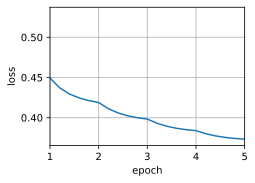

In [29]:
learning_rate, num_epochs = 0.01, 5
train(net, data_iter, learning_rate, num_epochs)

#### Test

We find the $k$ nearest words to the query, where we measure similarity using cosine similarity
$$\text{sim} = \frac{x^T y}{||x|| \; ||y||}$$


In [30]:
def get_similar_tokens(query_token, k, embed):
    W = embed.weight.data
    x = W[vocab[query_token]]
    # Compute the cosine similarity. Add 1e-9 for numerical stability
    cos = torch.mv(
        W, x) / torch.sqrt(torch.sum(W * W, dim=1) * torch.sum(x * x) + 1e-9)
    topk = torch.topk(cos, k=k + 1)[1].cpu().numpy().astype('int32')
    for i in topk[1:]:  # Remove the input words
        print(f'cosine sim={float(cos[i]):.3f}: {vocab.idx_to_token[i]}')


In [31]:

get_similar_tokens('chip', 3, net[0])

cosine sim=0.538: intel
cosine sim=0.465: computer
cosine sim=0.450: mips


In [32]:

get_similar_tokens('president', 3, net[0])

cosine sim=0.563: chief
cosine sim=0.554: executive
cosine sim=0.551: officer


In [33]:

get_similar_tokens('dog', 3, net[0])

cosine sim=0.439: man
cosine sim=0.434: beneath
cosine sim=0.426: loved


#### Pre-trained models

For better results, you should use a larger model that is trained on more data,
such as those provided by the [Spacy library](https://spacy.io/usage/linguistic-features#vectors-similarity). For a demo, see [this script](https://github.com/probml/pyprobml/blob/master/scripts/word_embedding_spacy.py).